<a href="https://colab.research.google.com/github/Hamakey/Kaggle_Study/blob/master/realEstatePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import requests, bs4
import pandas as pd
from lxml import html
from urllib.parse import urlencode, quote_plus, unquote
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import platform

from google.colab import drive
drive.mount('/content/drive')

if platform.system() == 'Windows':
    font_name = font_manager.FontPropertise(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family = font_name)
else:
    rc('font',family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus']=False

Mounted at /content/drive


In [5]:
#한국부동산원_아파트거래현황 조회 서비스 : 연간 지역별 아파트 거래횟수


def loadTradeCnt(startmonth,endmonth,region):
  url = 'http://openapi.reb.or.kr/OpenAPI_ToolInstallPackage/service/rest/AptTradingStateSvc/getAptTrdStateCaseOfNbr'
  ServiceKey = "HWl55GQ4cyBgljwQ9Xv3ea8ssbyiw6Dm4nouxkeDSlxhPeuwtcTIJ+KlWsWX3NtwqlPqQFpMtweXK2Y7XpOFBQ=="
  queryParams = '?' + urlencode({ quote_plus('ServiceKey') : ServiceKey, quote_plus('startmonth') : startmonth , quote_plus('endmonth') : endmonth, quote_plus('region') : region })
  request = requests.get(url + queryParams).text.encode("utf-8")
  xmlobj = bs4.BeautifulSoup(request, 'lxml-xml')
  rows = xmlobj.findAll('item')
  columns = rows[0].find_all()
  rowList = []
  nameList = []
  columnList = []
  for j in range(len(columns)):
    nameList.append(columns[j].name)
  nameList.append('tradeCnt')
  for date, cnt in map(lambda x : x.split(',') ,columns[2].text.split("|")):
    
    rowList.append([columns[0].text,columns[1].text,date,cnt])
  result = pd.DataFrame(rowList, columns = nameList)
  return result
trade_cnt_per_year = loadTradeCnt(201101,202107,11000)

In [6]:
#@title

#법정동 코드 해싱
lawd_cd = {
  '서울특별시' : [['강남구', '11680'], ['강동구', '11740'], ['강북구', '11305'], ['강서구', '11500'], ['관악구', '11620'], ['광진구', '11215'], ['구로구', '11530'], ['금천구', '11545'], ['노원구', '11350'], ['도봉구', '11320'], ['동대문구', '11230'], ['동작구', '11590'], ['마포구', '11440'], ['서대문구', '11410'], ['서초구', '11650'], ['성동구', '11200'], ['성북구', '11290'], ['송파구', '11710'], ['양천구', '11470'], ['영등포구', '11560'], ['용산구', '11170'], ['은평구', '11380'], ['종로구', '11110'], ['중구', '11140'], ['중랑구', '11260']] ,
  '부산광역시': [['강서구', '26440'], ['금정구', '26410'], ['기장군', '26710'], ['남구', '26290'], ['동구', '26170'], ['동래구', '26260'], ['부산진구', '26230'], ['북구', '26320'], ['사상구', '26530'], ['사하구', '26380'], ['서구', '26140'], ['수영구', '26500'], ['연제구', '26470'], ['영도구', '26200'], ['중구', '26110'], ['해운대구', '26350']] ,
  '대구광역시': [['남구', '27200'], ['달서구', '27290'], ['달성군', '27710'], ['동구', '27140'], ['북구', '27230'], ['서구', '27170'], ['수성구', '27260'], ['중구', '27110']],
  '인천광역시': [['강화군', '28710'], ['계양구', '28245'], ['남동구', '28200'], ['동구', '28140'], ['미추홀구', '28177'], ['부평구', '28237'], ['서구', '28260'], ['연수구', '28185'], ['옹진군', '28720'], ['중구', '28110']],
  '광주광역시' : [['광산구', '29200'], ['남구', '29155'], ['동구', '29110'], ['북구', '29170'], ['서구', '29140']],
  '대전광역시' : [['대덕구', '30230'], ['동구', '30110'], ['서구', '30170'], ['유성구', '30200'], ['중구', '30140']],
  '울산광역시' : [['남구', '31140'], ['동구', '31170'], ['북구', '31200'], ['울주군', '31710'], ['중구', '31110']],
  '세종특별자치시' : [['세종특별자치시', '36110']],
  '경기도' : [['가평군', '41820'], ['고양시 덕양구', '41281'], ['고양시 일산동구', '41285'], ['고양시 일산서구', '41287'], ['과천시', '41290'], ['광명시', '41210'], ['광주시', '41610'], ['구리시', '41310'], ['군포시', '41410'], ['김포시', '41570'], ['남양주시', '41360'], ['동두천시', '41250'], ['부천시', '41190'], ['성남시 분당구', '41135'], ['성남시 수정구', '41131'], ['성남시 중원구', '41133'], ['수원시 권선구', '41113'], ['수원시 영통구', '41117'], ['수원시 장안구', '41111'], ['수원시 팔달구', '41115'], ['시흥시', '41390'], ['안산시 단원구', '41273'], ['안산시 상록구', '41271'], ['안성시', '41550'], ['안양시 동안구', '41173'], ['안양시 만안구', '41171'], ['양주시', '41630'], ['양평군', '41830'], ['여주시', '41670'], ['연천군', '41800'], ['오산시', '41370'], ['용인시 기흥구', '41463'], ['용인시 수지구', '41465'], ['용인시 처인구', '41461'], ['의왕시', '41430'], ['의정부시', '41150'], ['이천시', '41500'], ['파주시', '41480'], ['평택시', '41220'], ['포천시', '41650'], ['하남시', '41450'], ['화성시', '41590']],
  '강원도' : [['강릉시', '42150'], ['고성군', '42820'], ['동해시', '42170'], ['삼척시', '42230'], ['속초시', '42210'], ['양구군', '42800'], ['양양군', '42830'], ['영월군', '42750'], ['원주시', '42130'], ['인제군', '42810'], ['정선군', '42770'], ['철원군', '42780'], ['춘천시', '42110'], ['태백시', '42190'], ['평창군', '42760'], ['홍천군', '42720'], ['화천군', '42790'], ['횡성군', '42730']],
  '충청북도' : [['괴산군', '43760'], ['단양군', '43800'], ['보은군', '43720'], ['영동군', '43740'], ['옥천군', '43730'], ['음성군', '43770'], ['제천시', '43150'], ['증평군', '43745'], ['진천군', '43750'], ['청주시 상당구', '43111'], ['청주시 서원구', '43112'], ['청주시 청원구', '43114'], ['청주시 흥덕구', '43113'], ['충주시', '43130']],
  '충청남도' : [['계룡시', '44250'], ['공주시', '44150'], ['금산군', '44710'], ['논산시', '44230'], ['당진시', '44270'], ['보령시', '44180'], ['부여군', '44760'], ['서산시', '44210'], ['서천군', '44770'], ['아산시', '44200'], ['예산군', '44810'], ['천안시 동남구', '44131'], ['천안시 서북구', '44133'], ['청양군', '44790'], ['태안군', '44825'], ['홍성군', '44800']],
  '전라북도': [['고창군', '45790'], ['군산시', '45130'], ['김제시', '45210'], ['남원시', '45190'], ['무주군', '45730'], ['부안군', '45800'], ['순창군', '45770'], ['완주군', '45710'], ['익산시', '45140'], ['임실군', '45750'], ['장수군', '45740'], ['전주시 덕진구', '45113'], ['전주시 완산구', '45111'], ['정읍시', '45180'], ['진안군', '45720']],
  '전라남도' : [['강진군', '46810'], ['고흥군', '46770'], ['곡성군', '46720'], ['광양시', '46230'], ['구례군', '46730'], ['나주시', '46170'], ['담양군', '46710'], ['목포시', '46110'], ['무안군', '46840'], ['보성군', '46780'], ['순천시', '46150'], ['신안군', '46910'], ['여수시', '46130'], ['영광군', '46870'], ['영암군', '46830'], ['완도군', '46890'], ['장성군', '46880'], ['장흥군', '46800'], ['진도군', '46900'], ['함평군', '46860'], ['해남군', '46820'], ['화순군', '46790']],
  '경상북도' : [['경산시', '47290'], ['경주시', '47130'], ['고령군', '47830'], ['구미시', '47190'], ['군위군', '47720'], ['김천시', '47150'], ['문경시', '47280'], ['봉화군', '47920'], ['상주시', '47250'], ['성주군', '47840'], ['안동시', '47170'], ['영덕군', '47770'], ['영양군', '47760'], ['영주시', '47210'], ['영천시', '47230'], ['예천군', '47900'], ['울릉군', '47940'], ['울진군', '47930'], ['의성군', '47730'], ['청도군', '47820'], ['청송군', '47750'], ['칠곡군', '47850'], ['포항시 남구', '47111'], ['포항시 북구', '47113']],
  '경상남도' : [['거제시', '48310'], ['거창군', '48880'], ['고성군', '48820'], ['김해시', '48250'], ['남해군', '48840'], ['밀양시', '48270'], ['사천시', '48240'], ['산청군', '48860'], ['양산시', '48330'], ['의령군', '48720'], ['진주시', '48170'], ['창녕군', '48740'], ['창원시 마산합포구', '48125'], ['창원시 마산회원구', '48127'], ['창원시 성산구', '48123'], ['창원시 의창구', '48121'], ['창원시 진해구', '48129'], ['통영시', '48220'], ['하동군', '48850'], ['함안군', '48730'], ['함양군', '48870'], ['합천군', '48890']],
  '제주특별자치도' : [['서귀포시', '50130'], ['제주시', '50110']]
}
lawd = {}
for city, datas in lawd_cd.items():
  lawd[city] = {}
  for sub, cd in datas:
    lawd[city][sub] = cd

In [68]:
#한국부동산원_아파트거래현황 조회 서비스 : 국토교통부_아파트 전월세 자료
def loadAPTTradeData(LAWD_CD, DEAL_YMD):

  url = 'http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptRent'
  serviceKey = 'HWl55GQ4cyBgljwQ9Xv3ea8ssbyiw6Dm4nouxkeDSlxhPeuwtcTIJ+KlWsWX3NtwqlPqQFpMtweXK2Y7XpOFBQ=='

  urlParams = '?' + urlencode({ quote_plus('serviceKey') : serviceKey, quote_plus('LAWD_CD') : LAWD_CD, quote_plus('DEAL_YMD') : DEAL_YMD})
  request = requests.get(url + urlParams).text.encode('utf-8')
  xmlobj = bs4.BeautifulSoup(request,'lxml-xml')
  rows = xmlobj.findAll('item')
  columns = rows[0].find_all()
  nameList = []
  res = []
  for i in range(len(columns)):
    nameList.append(columns[i].name)
  for j in range(len(rows)):
    rowList = []
    for k in rows[j]:
      if ',' in k.text.strip(): # strip은 데이터에 공백이 좌측에 들어가있으며, 우측또한 있을 경우 에러를 유발하므로 strip
        replacedK = k.text.strip().replace(',','') #보증금액은 , 가 string으로 들어가있어서 처리필요
        rowList.append(replacedK)
      else:
        rowList.append(k.text.strip())
    res.append(rowList)
  result = pd.DataFrame(res, columns = nameList)
  #data 형변환 int, float 등
  for i in result:
    try : 
      try :
        if float(result[i][0]):
            result[i] = pd.to_numeric(result[i])
      except :
          result[i] = result[i].astype(np.float)
    except :
          pass 

  from datetime import date
  filename = '{}_{}'.format(LAWD_CD,DEAL_YMD)
  result['date'] = result.apply(lambda x : date.isoformat(date(x['년'],x['월'],x['일'])), axis = 1 )
  result['date'] = pd.to_datetime(result['date'])
  result.to_csv('/content/drive/MyDrive/realEstatePrediction/{}.csv'.format(filename))

  return result

In [96]:
# #20개년 데이터 저장하기 수정필요
# for i in range(2001,2020,1):
#   for j in range(1,12):
#     period = i*100 + j
#     print(period)    
#     try:
#       loadAPTTradeData(lawd['서울특별시']['강서구'],int(period))
#     except:
      # pass
#20개년 데이터 저장하기 수정필요
fo                                                      r i in range(2001,2020,1):
  period = i*100 + 12
  print(period)    
  try:
    loadAPTTradeData(lawd['서울특별시']['강서구'],int(period))
  except:
    pass

200112
200212
200312
200412
200512
200612
200712
200812
200912
201012
201112
201212
201312
201412
201512
201612
201712
201812
201912


In [65]:
#파일 저장 함수
def save_data(obj,newname,types):
  try:
    if types == 'image':
      obj.savefig(('/content/drive/MyDrive/realEstatePrediction/{}.png'.format(newname)))
    elif types == 'csv':

      obj.to_csv('/content/drive/MyDrive/realEstatePrediction/{}.csv'.format(newname))
    elif types == 'excel':
      obj.to_excel('/content/drive/MyDrive/realEstatePrediction/{}.xls'.format(newname))
  except:
    print('Please check your path or target name or the file name you wanted to use')

UsageError: Line magic function `%f%f` not found.


In [32]:
APTTradeData.describe()

,건축년도,년,보증금액,월,월세금액,일,전용면적,지역코드,층
count,877.000000,877.0,877.000000,877.0,877.000000,877.000000,877.000000,877.0,877.000000
mean,2006.045610,2021.0,30492.058153,6.0,15.199544,15.115165,61.743436,11500.0,8.107184
std,10.588514,0.0,20585.325219,0.0,31.088548,7.750193,25.696087,0.0,4.295576
min,1982.000000,2021.0,500.000000,6.0,0.000000,1.000000,12.040000,11500.0,1.000000
25%,1995.000000,2021.0,12000.000000,6.0,0.000000,9.000000,49.500000,11500.0,5.000000
50%,2005.000000,2021.0,30000.000000,6.0,0.000000,15.000000,59.790000,11500.0,8.000000
75%,2016.000000,2021.0,45000.000000,6.0,17.000000,21.000000,84.830000,11500.0,11.000000
max,2021.000000,2021.0,95000.000000,6.0,210.000000,30.000000,156.876000,11500.0,23.000000


In [36]:
APTTradeData.index = APTTradeData['date']
APTTradeData.set_index(APTTradeData['date'],inplace = True)

No handles with labels found to put in legend.


Index(['744', '1485', '1461', '748', '904', '657', '1475', '751', '1159',
       '741',
       ...
       '672-15', '70-20', '614-11', '885', '1018-32', '867', '872', '902',
       '926-5', '674-32'],
      dtype='object', length=220)


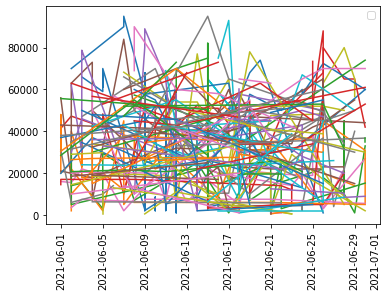

In [42]:
# plt.plot(APTTradeData['아파트']['보증금액'])

# for i in (APTTradeData['지번'].value_counts() < 5).index.unique():
#   plt.plot(APTTradeData['보증금액'][APTTradeData['지번'] == i])
# print((APTTradeData['지번'].value_counts() < 5).index)
# print(b)
# plt.bar(APTTradeData['지번'].unique(),APTTradeData['지번'].value_counts() )
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [16]:
APTTradeData.describe()

,건축년도,년,보증금액,월,월세금액,일,전용면적,지역코드,층
count,871.000000,871.0,871.000000,871.0,871.000000,871.000000,871.000000,871.0,871.000000
mean,2006.084960,2021.0,30489.512055,6.0,14.985075,15.081515,61.697713,11500.0,8.112514
std,10.586682,0.0,20522.404376,0.0,30.793021,7.707976,25.735533,0.0,4.295008
min,1982.000000,2021.0,500.000000,6.0,0.000000,1.000000,12.040000,11500.0,1.000000
25%,1995.000000,2021.0,12000.000000,6.0,0.000000,9.000000,49.500000,11500.0,5.000000
50%,2006.000000,2021.0,30000.000000,6.0,0.000000,15.000000,59.790000,11500.0,8.000000
75%,2016.000000,2021.0,45000.000000,6.0,16.000000,21.000000,84.825000,11500.0,11.000000
max,2021.000000,2021.0,95000.000000,6.0,210.000000,30.000000,156.876000,11500.0,23.000000


<BarContainer object of 36 artists>

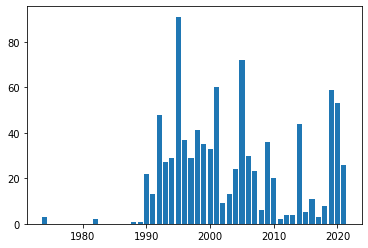

In [77]:
#건축년도별 아파트수량 점검 시 초기개발
a = APTTradeData['건축년도'].value_counts()
plt.bar(APTTradeData['건축년도'].unique(),a)

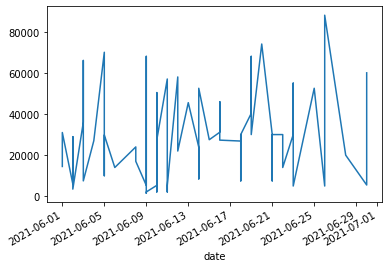

In [52]:
APTTradeData[APTTradeData['건축년도'] > 2018]['보증금액'].plot()

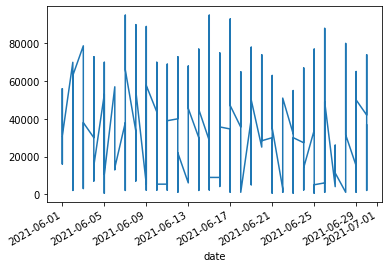

In [55]:
APTTradeData[APTTradeData['전용면적']>15]['보증금액'].plot()